In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns


e:\Formation\Projets\OnboardSystem\OnboadSystem_Model\monenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [2]:
import os

# Répertoire racine de Cityscapes
CITYSCAPES_ROOT = "../data"  # ⚠️ À adapter

# Images et masques, par split
LEFTIMG_DIR = os.path.join(CITYSCAPES_ROOT, "leftImg8bit")
MASK_DIR    = os.path.join(CITYSCAPES_ROOT, "gtFine")

# Chemins complets
TRAIN_IMG_DIR = os.path.join(LEFTIMG_DIR, "train")
VAL_IMG_DIR   = os.path.join(LEFTIMG_DIR, "val")
TEST_IMG_DIR  = os.path.join(LEFTIMG_DIR, "test")

TRAIN_MASK_DIR = os.path.join(MASK_DIR, "train")
VAL_MASK_DIR   = os.path.join(MASK_DIR, "val")
TEST_MASK_DIR  = os.path.join(MASK_DIR, "test")

# Autres paramètres globaux
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 8
IMG_WIDTH, IMG_HEIGHT = 256, 128
IMG_SIZE = (256, 128)
BATCH_SIZE = 4

torch.cuda.is_available()


True

In [3]:
# Dossier racine
base_path = "../data"

# Exemple avec une image de validation
city = "frankfurt"
image_name = "frankfurt_000000_000294_leftImg8bit.png"

# Chemins
image_path = os.path.join(base_path, "leftImg8bit", "val", city, image_name)
mask_path = os.path.join(base_path, "gtFine", "val", city, image_name.replace("leftImg8bit", "gtFine_labelIds"))

# Chargement
image = Image.open(image_path)
mask = Image.open(mask_path)

# Conversion en array
image_np = np.array(image)
mask_np = np.array(mask)


In [4]:
# Mapping de l’ID des classes vers les 8 catégories principales
CITYSCAPES_8_CLASSES = {
        # flat
        7: 0, 8: 0, 9: 7, 10: 7,  # road, sidewalk, parking, rail track

        # human
        24: 1, 25: 1,  # person, rider

        # vehicle
        26: 2, 27: 2, 28: 2, 29: 2, 30: 2, 31: 2, 32: 2, 33: 2,  # car, truck, bus, train, motorcycle, etc.

        # construction
        11: 3, 12: 3, 13: 3, 14: 3, 15: 3, 16: 3, 17: 4,  # building, wall, fence, etc.

        # object
        18: 4, 19: 4, 20: 4,  # pole, traffic light/sign

        # nature
        21: 5, 22: 5,  # vegetation, terrain

        # sky
        23: 6,  # sky

        # void (tout le reste → 7)
}

def remap_mask(mask):
    """Transforme les classes Cityscapes en 8 classes cibles (valeurs 0 à 7)"""
    mask_array = np.array(mask)
    new_mask = np.zeros_like(mask_array)

    for k, v in CITYSCAPES_8_CLASSES.items():
        new_mask[mask_array == k] = v

    return new_mask.astype(np.int64)  # ✅ conversion explicite



In [5]:
import albumentations as A
from albumentations.pytorch import ToTensorV2




train_transform = A.Compose([
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0]),  # (960, 1920)
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0]),  # (960, 1920)
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

test_transform =  A.Compose([
    A.Resize(height=IMG_SIZE[1], width=IMG_SIZE[0]),  # (960, 1920)
    A.HorizontalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


In [6]:
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = Image.open(self.mask_paths[idx])
        mask = remap_mask(mask)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        return image, mask.long()


In [7]:
import glob
def get_cityscapes_pairs(img_root, mask_root, split="train"):
    image_paths = []
    mask_paths = []

    for city in os.listdir(img_root):
        img_files = glob.glob(os.path.join(img_root, city, "*_leftImg8bit.png"))
        for img_path in img_files:
            # Extrait le nom de fichier sans extension
            filename = os.path.basename(img_path).replace("_leftImg8bit.png", "")
            mask_path = os.path.join(mask_root, city, f"{filename}_gtFine_labelIds.png")

            if os.path.exists(mask_path):
                image_paths.append(img_path)
                mask_paths.append(mask_path)
            else:
                print(f"❌ Masque non trouvé pour : {mask_path}")

    print(f"✅ {split} : {len(image_paths)} paires valides trouvées")
    return image_paths, mask_paths


In [8]:
train_img, train_mask = get_cityscapes_pairs(TRAIN_IMG_DIR, TRAIN_MASK_DIR, "train")
val_img, val_mask = get_cityscapes_pairs(VAL_IMG_DIR, VAL_MASK_DIR, "val")


✅ train : 2975 paires valides trouvées
✅ val : 500 paires valides trouvées


In [9]:
train_dataset = SegmentationDataset(train_img, train_mask, transform=train_transform)
val_dataset = SegmentationDataset(val_img, val_mask, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [10]:
def denormalize(image_tensor, mean, std):
    """
    Dénormalise un tenseur image normalisé.
    """
    device = image_tensor.device  # 👈 On récupère le device de l'image
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)
    return (image_tensor * std + mean).clamp(0, 1)


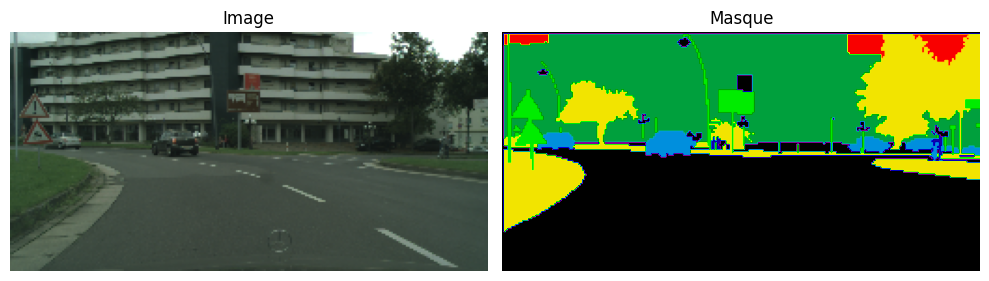

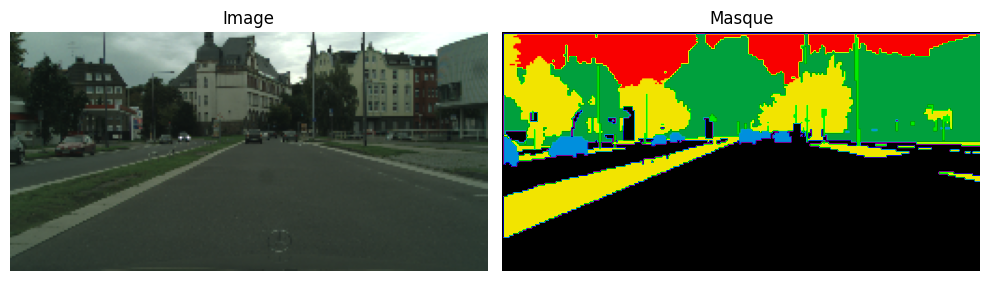

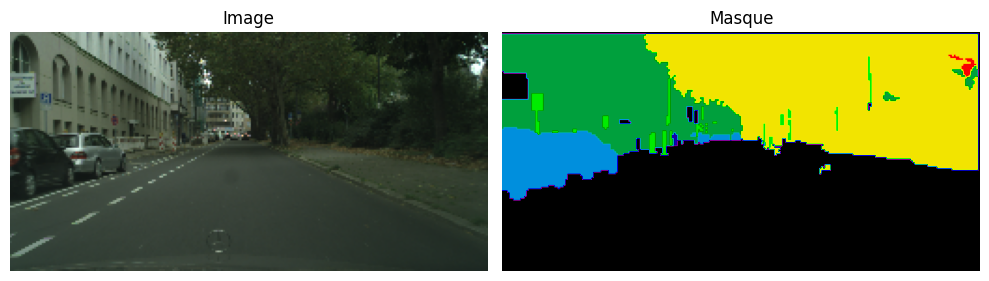

In [11]:
import matplotlib.pyplot as plt

def show_sample(dataset, n=3):
    """
    Affiche n paires (image, masque) à partir d'un dataset PyTorch.
    """

    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    for i in range(n):
        image, mask = dataset[i]
        image = denormalize(image, mean, std)
        
        # Conversion pour affichage
        image_np = image.permute(1, 2, 0).cpu().numpy()
        mask_np = mask.cpu().numpy()
        
        # Affichage
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image_np)
        axs[0].set_title("Image")
        axs[0].axis("off")
        
        axs[1].imshow(mask_np, cmap="nipy_spectral", vmin=0, vmax=NUM_CLASSES-1)
        axs[1].set_title("Masque")
        axs[1].axis("off")
        
        plt.tight_layout()
        plt.show()

show_sample(train_dataset)


In [12]:
def get_test_images(img_root, n=3):
    test_images = []

    for city in os.listdir(img_root):
        img_files = glob.glob(os.path.join(img_root, city, "*_leftImg8bit.png"))
        img_files.sort()  # pour la reproductibilité

        for img_path in img_files:
            test_images.append(img_path)
            if len(test_images) >= n:
                break
        if len(test_images) >= n:
            break

    print(f"✅ test : {len(test_images)} images chargées pour prédiction")
    return test_images


In [13]:
test_img_paths = get_test_images(TEST_IMG_DIR, n=3)


✅ test : 3 images chargées pour prédiction


In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2



In [15]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, img_path



In [16]:
test_dataset = TestDataset(test_img_paths, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [17]:

from collections import Counter
import numpy as np

label_counts = Counter()

for i in range(100):  # Prends un sous-ensemble du dataset
    _, mask = train_dataset[i]
    labels, counts = np.unique(mask, return_counts=True)
    for l, c in zip(labels, counts):
        label_counts[int(l)] += int(c)

print("Distribution des classes (sur 100 images) :")
for k in sorted(label_counts):
    print(f"Classe {k} → {label_counts[k]}")


Distribution des classes (sur 100 images) :
Classe 0 → 1547043
Classe 1 → 36583
Classe 2 → 229546
Classe 3 → 840761
Classe 4 → 57142
Classe 5 → 452996
Classe 6 → 87507
Classe 7 → 25222


#### 2.1. Modèle Baseline (U-Net simple ou FCN)



## 2.1. Modèle Baseline (U-Net simple ou FCN)

In [18]:
import mlflow
import mlflow.pytorch
import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch


# ✅ Fonction de perte (pour classification pixel à pixel)
loss_fn = nn.CrossEntropyLoss()
BEST_METRIC = -float("inf")
PATIENCE = 3
PATIENCE_COUNTER = 0
EPOCHS = 10
LEARNING_RATE = 1e-4


In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetBaseline(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):
        super(UNetBaseline, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        # Bottleneck
        b = self.bottleneck(self.pool(e3))

        # Decoder
        d3 = self.up3(b)
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        return self.final(d1)


In [20]:
def compute_metrics(preds, targets, num_classes):
    preds = torch.argmax(preds, dim=1)

    ious = []
    correct_pixels = 0
    total_pixels = 0

    for cls in range(num_classes):
        pred_mask = preds == cls
        target_mask = targets == cls

        intersection = (pred_mask & target_mask).sum().item()
        union = (pred_mask | target_mask).sum().item()

        if union == 0:
            iou = float('nan')  # ignore class not present
        else:
            iou = intersection / union
            ious.append(iou)

        correct_pixels += (pred_mask == target_mask).sum().item()
        total_pixels += target_mask.numel()

    pixel_acc = correct_pixels / total_pixels
    mean_iou = np.nanmean(ious)

    return mean_iou, pixel_acc


In [21]:
def train_one_epoch(model, loader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0.0

    for images, masks in loader:
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        if isinstance(model(images), dict):
            outputs = model(images)["out"]
        else:
            outputs = model(images)
        if outputs.shape[-2:] != masks.shape[-2:]:
            outputs = nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


In [22]:
def evaluate_model(model, loader, loss_fn, device, num_classes):
    model.eval()
    val_loss = 0.0
    total_iou = 0.0
    total_acc = 0.0
    n_batches = 0

    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            if isinstance(model(images), dict):
                outputs = model(images)["out"]
            else:
                outputs = model(images)
            if outputs.shape[-2:] != masks.shape[-2:]:
                outputs = nn.functional.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()

            iou, acc = compute_metrics(outputs, masks, num_classes)
            total_iou += iou
            total_acc += acc
            n_batches += 1

    return (
        val_loss / n_batches,
        total_iou / n_batches,
        total_acc / n_batches
    )


In [23]:
model = UNetBaseline(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")



with mlflow.start_run(run_name="UNet_baseline"):
    mlflow.log_params({
        "model": "UNetBaseline",
        "optimizer": "Adam",
        "lr": 1e-4,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model.state_dict(), "best_model.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model.pt")


In [ ]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model(input_tensor)  # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


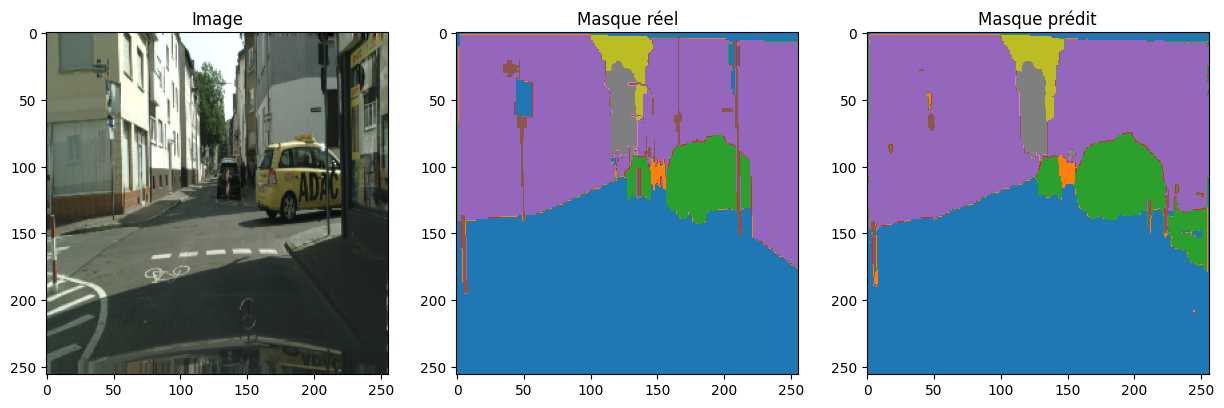

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


#### 2.2. Modèle From Scratch (U-Net complet)


In [ ]:
import torch
import torch.nn as nn

class UNetFull(nn.Module):
    def __init__(self, in_channels=3, num_classes=8):
        super(UNetFull, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Bottleneck
        b = self.bottleneck(self.pool(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = torch.cat((d4, e4), dim=1)
        d4 = self.dec4(d4)

        d3 = self.upconv3(d4)
        d3 = torch.cat((d3, e3), dim=1)
        d3 = self.dec3(d3)

        d2 = self.upconv2(d3)
        d2 = torch.cat((d2, e2), dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat((d1, e1), dim=1)
        d1 = self.dec1(d1)

        return self.final_conv(d1)


In [ ]:
import torch.optim as optim
import mlflow
import mlflow.pytorch

model2 = UNetFull(in_channels=3, num_classes=NUM_CLASSES).to(DEVICE)
# ✅ Optimiseur
optimizer = optim.Adam(model2.parameters(), lr=LEARNING_RATE)



In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
PATIENCE_COUNTER = 0
with mlflow.start_run(run_name="UNet_Full"):
    mlflow.log_params({
        "model": "UNetFull",
        "optimizer": "Adam",
        "lr": LEARNING_RATE,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model2, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model2, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model2.state_dict(), "best_model2.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model2.pt")


Époch 1 | Train Loss: 0.6223 | Val Loss: 0.4810 | mIoU: 0.4421 | Pixel Acc: 0.9616
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 2 | Train Loss: 0.4305 | Val Loss: 0.4899 | mIoU: 0.4594 | Pixel Acc: 0.9586
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 3 | Train Loss: 0.3845 | Val Loss: 0.3864 | mIoU: 0.5216 | Pixel Acc: 0.9682
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 4 | Train Loss: 0.3496 | Val Loss: 0.3405 | mIoU: 0.5511 | Pixel Acc: 0.9727
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 5 | Train Loss: 0.3280 | Val Loss: 0.3272 | mIoU: 0.5576 | Pixel Acc: 0.9734
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 6 | Train Loss: 0.3125 | Val Loss: 0.3333 | mIoU: 0.5611 | Pixel Acc: 0.9733
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 7 | Train Loss: 0.2957 | Val Loss: 0.3036 | mIoU: 0.5644 | Pixel Acc: 0.9750
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 8 | Train Loss: 0.2905 | Val Loss: 

In [ ]:
model2.load_state_dict(torch.load("best_model2.pt"))
model2.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model2(input_tensor)  # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


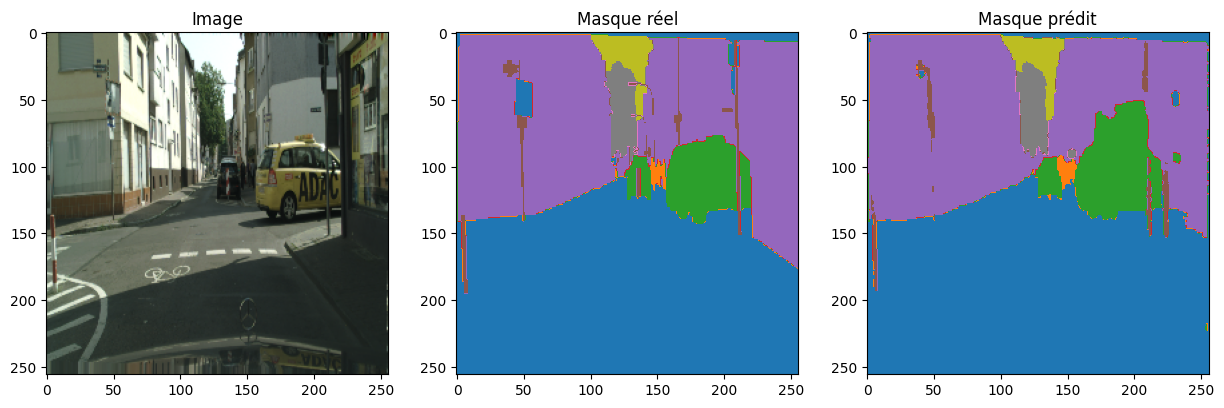

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


In [ ]:
def afficher_prediction(image_tensor, pred_mask, path, mean, std, num_classes):
    # Dénormaliser
    image_denorm = denormalize(image_tensor.squeeze(0), mean=mean, std=std)
    image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
    pred_np = pred_mask  # déjà en numpy

    # Affichage
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    axs[0].imshow(image_np)
    axs[0].set_title("Image")
    axs[1].imshow(pred_np, cmap="tab10", vmin=0, vmax=num_classes - 1)
    axs[1].set_title("Masque prédit")

    fig.suptitle(f"🖼️ {os.path.basename(path)}")
    plt.show()


e:\Formation\Projets\OnboardSystem\OnboadSystem_Model\monenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


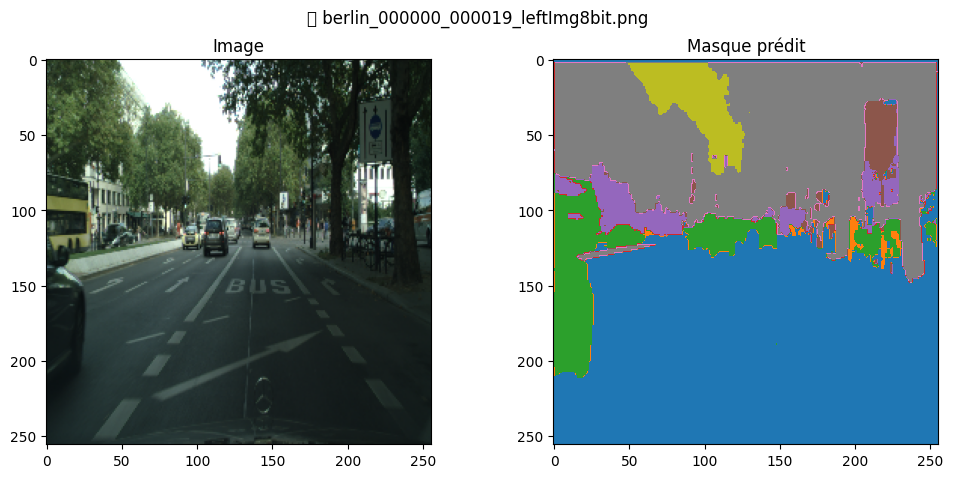

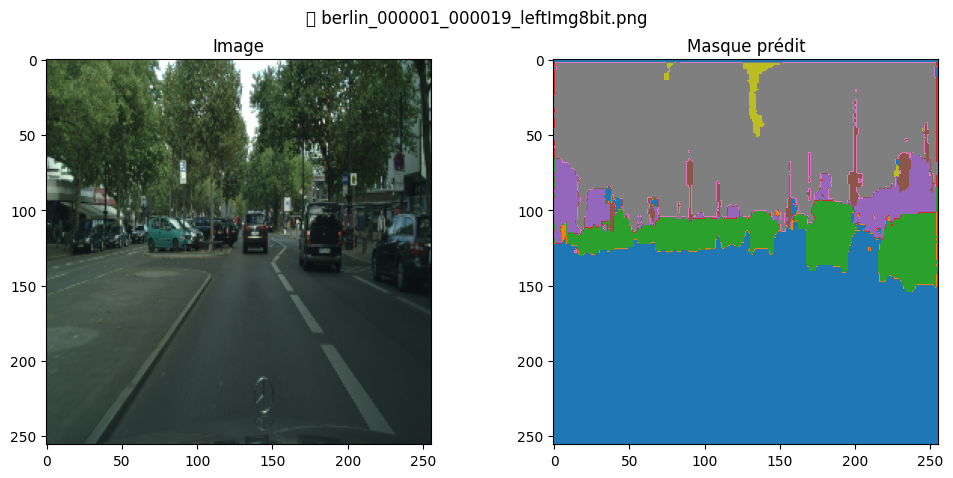

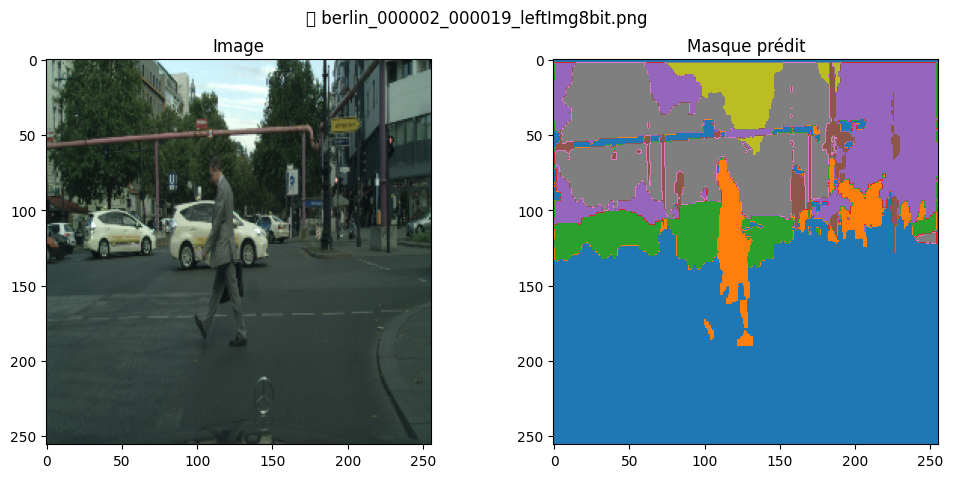

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model2.eval()
with torch.no_grad():
    for img_tensor, path in test_loader:
        img_tensor = img_tensor.to(DEVICE)
        output = model2(img_tensor)
        pred_mask = output.argmax(1).squeeze(0).cpu().numpy()

        afficher_prediction(img_tensor, pred_mask, path[0], mean, std, NUM_CLASSES)



#### 2.3. Modèle Transfert Learning ( U-Net + ResNet34)

In [ ]:
import segmentation_models_pytorch as smp

def get_unet_resnet34_model(num_classes=8):
    model = smp.Unet(
        encoder_name="resnet34",          # backbone
        encoder_weights="imagenet",       # transfert learning
        in_channels=3,                    # RGB
        classes=num_classes               # segmentation des 8 classes
    )
    return model


In [ ]:
model3 = get_unet_resnet34_model(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model3.parameters(), lr=LEARNING_RATE)




In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
PATIENCE_COUNTER = 0
with mlflow.start_run(run_name="UNet_ResNet34"):

    mlflow.log_params({
        "model": "UNet_ResNet34",
        "optimizer": "Adam",
        "lr": LEARNING_RATE,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model3, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model3, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model3.state_dict(), "best_model_unet_resnet34.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model_unet_resnet34.pt")


KeyboardInterrupt: 

In [ ]:
model3.load_state_dict(torch.load("best_model_unet_resnet34.pt"))
model3.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model2(input_tensor)  # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


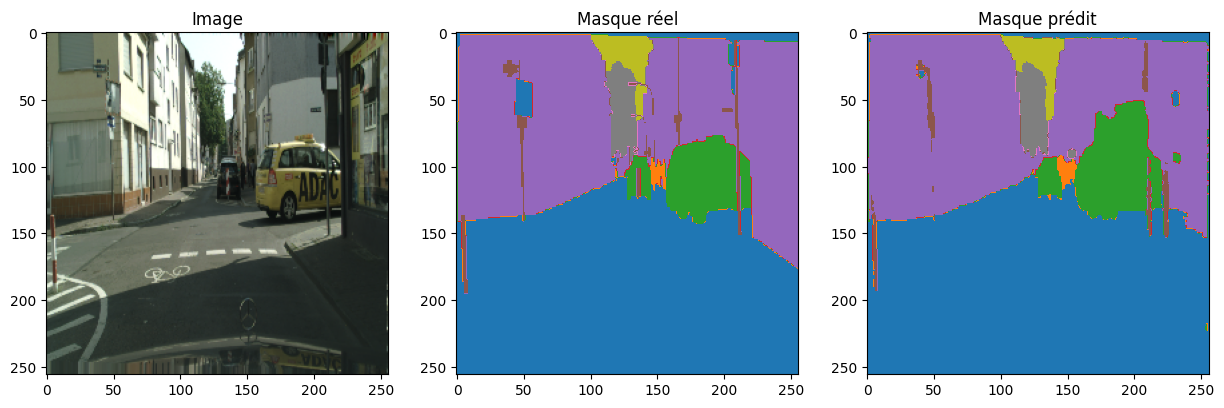

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


e:\Formation\Projets\OnboardSystem\OnboadSystem_Model\monenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


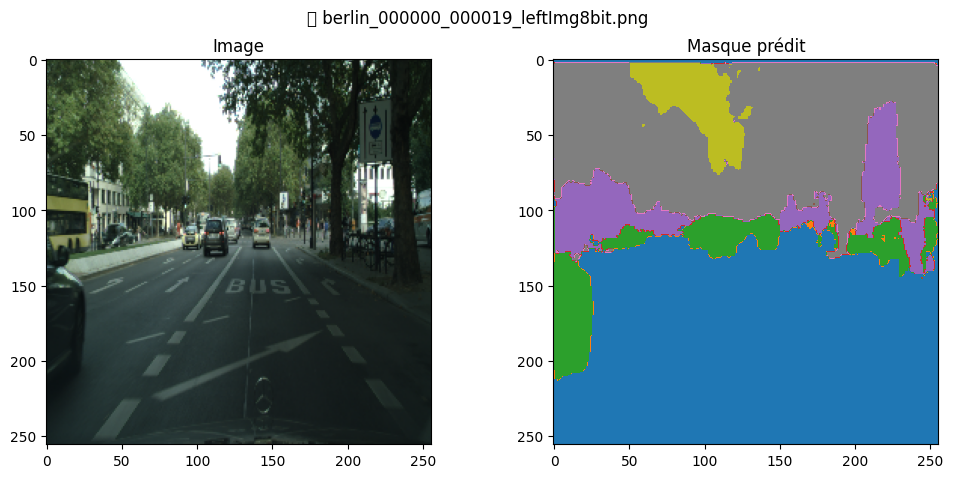

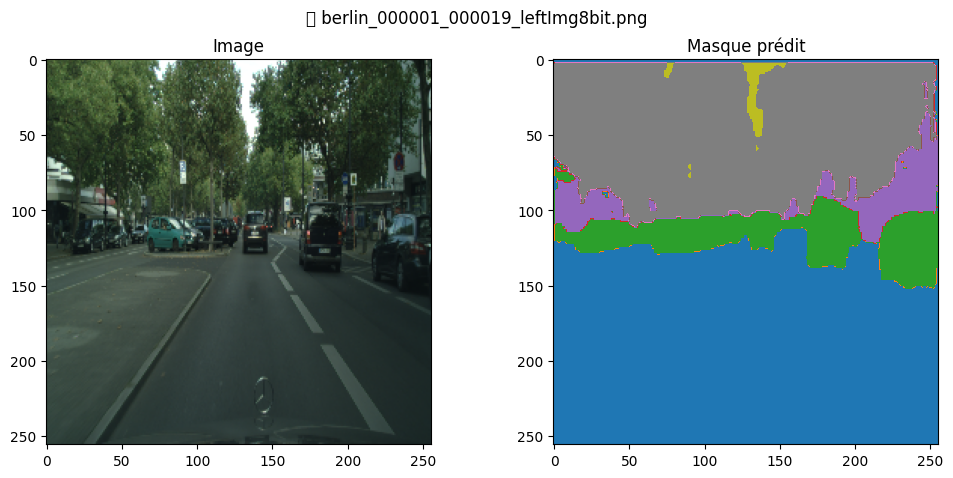

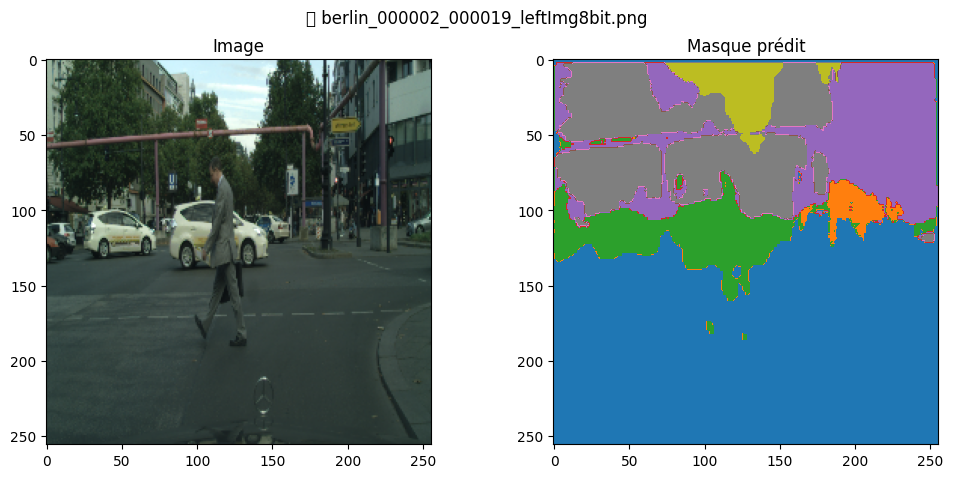

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model3.eval()
with torch.no_grad():
    for img_tensor, path in test_loader:
        img_tensor = img_tensor.to(DEVICE)
        output = model3(img_tensor)
        pred_mask = output.argmax(1).squeeze(0).cpu().numpy()

        afficher_prediction(img_tensor, pred_mask, path[0], mean, std, NUM_CLASSES)



# Unet + Resnet50 custom

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class ResNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
        self.stage0 = nn.Sequential(base.conv1, base.bn1, base.relu)                 # 128×128
        self.stage1 = nn.Sequential(base.maxpool, base.layer1)                        # 64×64
        self.stage2 = base.layer2                                                     # 32×32
        self.stage3 = base.layer3                                                     # 16×16
        self.stage4 = base.layer4                                                     # 8×8

    def forward(self, x):
        x0 = self.stage0(x)
        x1 = self.stage1(x0)
        x2 = self.stage2(x1)
        x3 = self.stage3(x2)
        x4 = self.stage4(x3)
        return x0, x1, x2, x3, x4

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.conv = nn.Sequential(
            nn.Conv2d(out_ch + skip_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        if x.shape[-2:] != skip.shape[-2:]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode="bilinear", align_corners=False)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)



In [ ]:
class UNetResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.encoder = ResNetEncoder()

        self.center = nn.Sequential(
            nn.Conv2d(2048, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2)  # de 8×8 → 16×16
        )

        self.dec4 = DecoderBlock(1024, 1024, 512)  # 16 → 32
        self.dec3 = DecoderBlock(512, 512, 256)    # 32 → 64
        self.dec2 = DecoderBlock(256, 256, 128)    # 64 → 128
        self.dec1 = DecoderBlock(128, 64, 64)      # 128 → 256

        self.final = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        x0, x1, x2, x3, x4 = self.encoder(x)

        x = self.center(x4)
        x = self.dec4(x, x3)
        x = self.dec3(x, x2)
        x = self.dec2(x, x1)
        x = self.dec1(x, x0)

        x = self.final(x)

        return x


In [ ]:
model4 = UNetResNet(num_classes=8).to(DEVICE)
optimizer = torch.optim.Adam(model4.parameters(), lr=LEARNING_RATE)



In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
with mlflow.start_run(run_name="UNet_ResNet50_Custom"):

    mlflow.log_params({
        "model": "UNet_Custom_ResNet50",
        "optimizer": "Adam",
        "lr": LEARNING_RATE,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model4, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model4, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model4.state_dict(), "best_model_unet_custom_resnet50.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model_unet_custom_resnet50.pt")


Époch 1 | Train Loss: 2.1418 | Val Loss: 2.1472 | mIoU: 0.0083 | Pixel Acc: 0.7583
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 2 | Train Loss: 2.1418 | Val Loss: 2.1469 | mIoU: 0.0083 | Pixel Acc: 0.7585
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 3 | Train Loss: 2.1415 | Val Loss: 2.1474 | mIoU: 0.0082 | Pixel Acc: 0.7583
⚠️ Pas d'amélioration : 1/5
Époch 4 | Train Loss: 2.1419 | Val Loss: 2.1485 | mIoU: 0.0083 | Pixel Acc: 0.7582
✅ Nouvelle meilleure performance - modèle sauvegardé.


KeyboardInterrupt: 

In [ ]:
model4.load_state_dict(torch.load("best_model_unet_custom_resnet50.pt"))
model4.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model2(input_tensor)  # [1, num_classes, H, W]
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model4.eval()
with torch.no_grad():
    for img_tensor, path in test_loader:
        img_tensor = img_tensor.to(DEVICE)
        output = model4(img_tensor)
        pred_mask = output.argmax(1).squeeze(0).cpu().numpy()

        afficher_prediction(img_tensor, pred_mask, path[0], mean, std, NUM_CLASSES)



# DeeplabV3 et ResNet50

In [ ]:
import torchvision

import torchvision.models.segmentation as models
from torchvision.models.segmentation import deeplabv3_resnet50

from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

def get_deeplabv3_model(num_classes=8):
    model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1)
    model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=1)
    return model


In [ ]:
model5 = get_deeplabv3_model(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model5.parameters(), lr=LEARNING_RATE)



0.6%

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to C:\Users\misss/.cache\torch\hub\checkpoints\deeplabv3_resnet50_coco-cd0a2569.pth


100.0%


In [ ]:
mlflow.set_experiment("UNet_segmentation_cityscapes")

BEST_METRIC = -float("inf")
PATIENCE_COUNTER = 0
with mlflow.start_run(run_name="DeepLabV3_ResNet50"):

    mlflow.log_params({
        "model": "DeepLabV3_ResNet50",
        "optimizer": "Adam",
        "lr": LEARNING_RATE,
        "loss": "CrossEntropy",
        "batch_size": BATCH_SIZE,
        "img_size": IMG_SIZE,
        "epochs": EPOCHS
    })

    for epoch in range(EPOCHS):
        train_loss = train_one_epoch(model5, train_loader, optimizer, loss_fn, DEVICE)
        val_loss, val_iou, val_acc = evaluate_model(model5, val_loader, loss_fn, DEVICE, NUM_CLASSES)

        mlflow.log_metrics({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_iou": val_iou,
            "val_pixel_acc": val_acc
        }, step=epoch)

        print(f"Époch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | mIoU: {val_iou:.4f} | Pixel Acc: {val_acc:.4f}")

        if val_iou > BEST_METRIC:
            BEST_METRIC = val_iou
            PATIENCE_COUNTER = 0
            torch.save(model5.state_dict(), "best_model_deeplabv3.pt")
            print("✅ Nouvelle meilleure performance - modèle sauvegardé.")
        else:
            PATIENCE_COUNTER += 1
            print(f"⚠️ Pas d'amélioration : {PATIENCE_COUNTER}/{PATIENCE}")

        if PATIENCE_COUNTER >= PATIENCE:
            print("⛔ Early stopping déclenché.")
            break

    mlflow.log_metric("best_val_iou", BEST_METRIC)
    mlflow.log_artifact("best_model_deeplabv3.pt")


Époch 1 | Train Loss: 0.4437 | Val Loss: 0.3620 | mIoU: 0.5218 | Pixel Acc: 0.9701
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 2 | Train Loss: 0.3239 | Val Loss: 0.3761 | mIoU: 0.5343 | Pixel Acc: 0.9675
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 3 | Train Loss: 0.2947 | Val Loss: 0.4083 | mIoU: 0.5534 | Pixel Acc: 0.9679
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 4 | Train Loss: 0.2812 | Val Loss: 0.2953 | mIoU: 0.5718 | Pixel Acc: 0.9744
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 5 | Train Loss: 0.2639 | Val Loss: 0.2915 | mIoU: 0.5826 | Pixel Acc: 0.9748
✅ Nouvelle meilleure performance - modèle sauvegardé.
Époch 6 | Train Loss: 0.2583 | Val Loss: 0.2853 | mIoU: 0.5820 | Pixel Acc: 0.9748
⚠️ Pas d'amélioration : 1/5
Époch 7 | Train Loss: 0.2451 | Val Loss: 0.2804 | mIoU: 0.5820 | Pixel Acc: 0.9750
⚠️ Pas d'amélioration : 2/5
Époch 8 | Train Loss: 0.2416 | Val Loss: 0.2839 | mIoU: 0.5780 | Pixel Acc: 0.9756
⚠️ Pas d'a

In [ ]:
model5.load_state_dict(torch.load("best_model_deeplabv3.pt"))
model5.eval()
image, mask = val_dataset[0]  # ou un autre indice
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1, 3, H, W]
    output = model2(input_tensor)  # [1, num_classes, H, W]
    output = F.interpolate(output, size=IMG_SIZE, mode="bilinear", align_corners=False)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # [H, W]


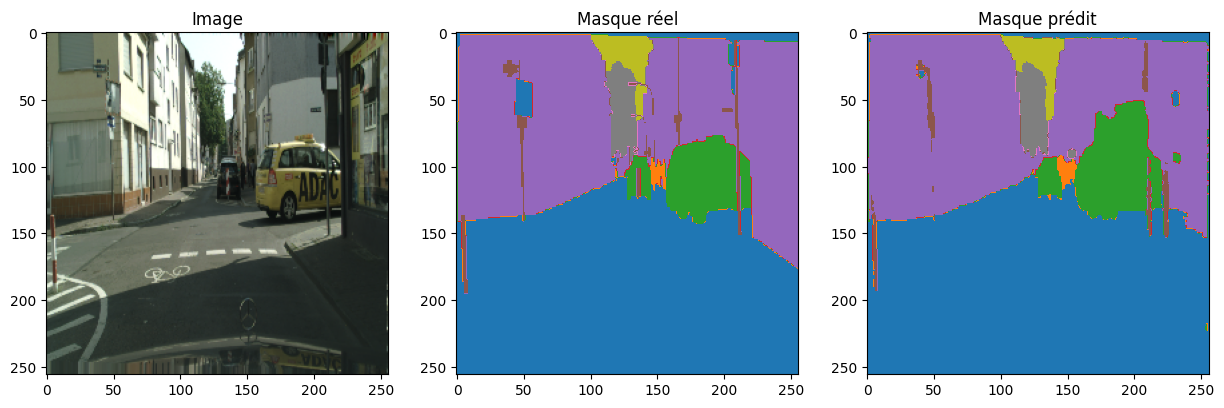

In [ ]:
# Dénormaliser pour affichage
image_denorm = denormalize(image, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
image_np = image_denorm.permute(1, 2, 0).cpu().numpy()
mask_np = mask.cpu().numpy()

# Affichage
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(image_np)
axs[0].set_title("Image")
axs[1].imshow(mask_np, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[1].set_title("Masque réel")
axs[2].imshow(pred, cmap="tab10", vmin=0, vmax=NUM_CLASSES-1)
axs[2].set_title("Masque prédit")
plt.show()


e:\Formation\Projets\OnboardSystem\OnboadSystem_Model\monenv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


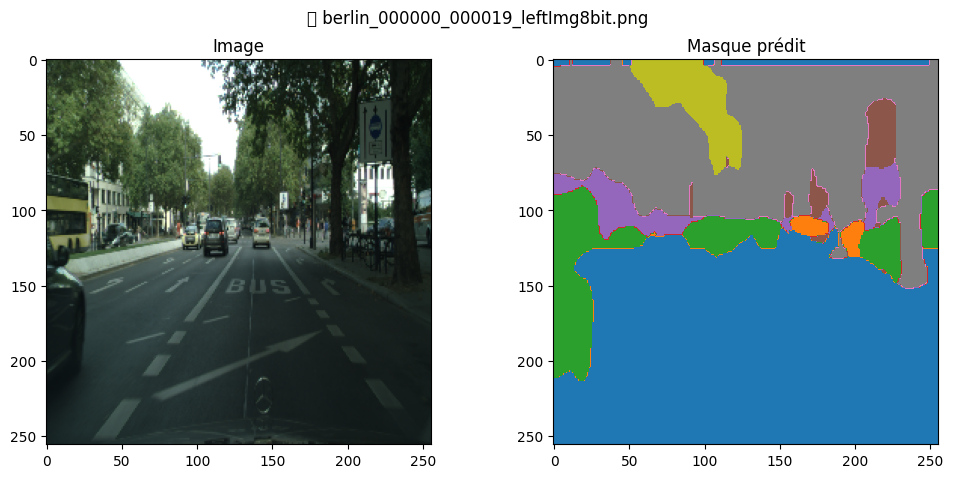

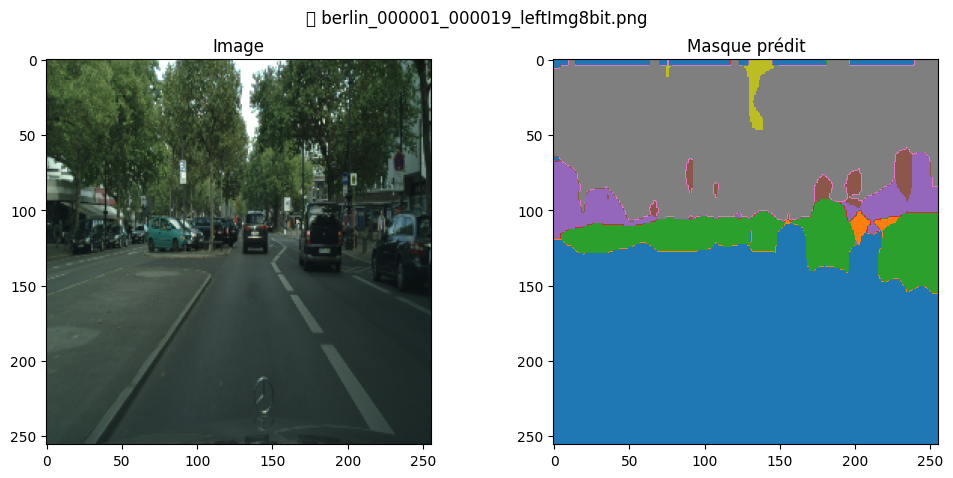

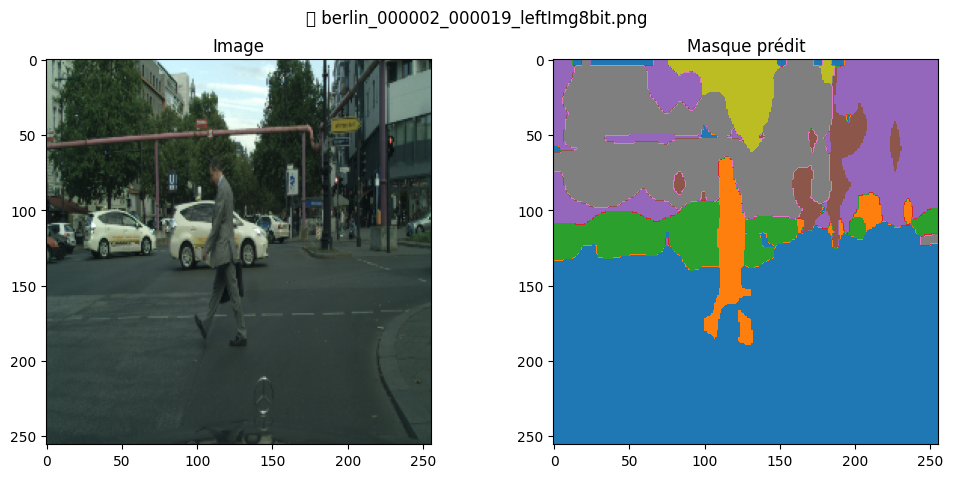

In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

model5.eval()
with torch.no_grad():
    for img_tensor, path in test_loader:
        img_tensor = img_tensor.to(DEVICE)
        output = model5(img_tensor)
        pred_mask = output["out"].argmax(1).squeeze(0).cpu().numpy()


        afficher_prediction(img_tensor, pred_mask, path[0], mean, std, NUM_CLASSES)

